<a href="https://colab.research.google.com/github/fderqaoui/cuda/blob/main/Programmation_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cet exercice a été réalisé à partir des exemples suivants :

*   https://www.vincent-lunot.com/tags/cuda/
*   https://github.com/ContinuumIO/gtc2019-numba

Certaines parties ne sont plus à jour, beaucoup de changements ont eu lieux en moins de 5 ans et certains des exemples ne fonctionnent exactement comme dans les articles.

Vérification des versions des outils que l'on va avoir besoin.

In [ ]:
import sys
import numba 
import numpy

print("Python version:", sys.version)
print("Numba version:", numba.__version__)
print("Numpy version:", numpy.__version__)

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Numba version: 0.51.2
Numpy version: 1.21.6


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


Lien intéressant de ce qui n'est pas supporté avec CUDA : http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html

Par exemple : try, with, dictionnaires, generateurs (yield)

Les méthodes qui créent des tableaux dynamiques ne sont pas supportées.

# L'importance de Numpy et Numba

Numpy est vraiment utile pour la manipulation d'importante quantité de valeurs numériques.  Il sera utilisé tout au long des exercices.

Numba est un module python qui est écrit en C++, il permet d'exécuter et compiler des scripts python.  Il rend aussi les scripts non typés de python et les rendre typés.  Ce qui améliore grandement le temps de réponse de plusieurs fonctions python.  Utiliser numba a un "overhead" cependant et peut ne pas améliorer les performances de façons significatives si les opérations ne demandes pas beaucoup d'opérations.

In [ ]:
from numba import cuda
import numpy as np

In [ ]:
@cuda.jit
def cudakernel0(array):
    for i in range(array.size):
        array[i] += .5

Note importante, avant de lancer cette cellule dans Colab, s'assurer de mettre le mode d'exécution en GPU.  

Cliquez sur l'endroit où c'est écrit RAM et Disque : 
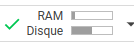


Ensuite, dans le bas, cliquer sur "Modifier le type d'exécution" et choisir dans "Accélération matérielle" GPU.

Ici un exemple simple, qui initialise un tableau avec seulement un 0 et un 1 dedans.  On passe ensuite ce tableau à notre méthode qui elle ira copiée les données vers le GPU fera le calcul (+ 0.5) et retournera ensuite la valeur pour être affichée.

In [ ]:
array = np.array([0,1], np.float32)
print('initial array:', array)

print('Kernel launch: cudakernel0[1,1](array)')
cudakernel0[1,1](array)

print('Updated array:', array)

initial array: [0. 1.]
Kernel launch: cudakernel0[1,1](array)
Updated array: [0.5 1.5]


La partie entre brackets [] représente le nombre de grilles et nombre de blocs. Le nombre de thread est la multiplication des deux.

*Les avertissements (warnings) que l'on voit plus haut nous indique que nous sous-utilisons le GPU pour notre opération et que les performances seront automatiquement affectées parce que simplement le fait de transférer les données du CPU vers le GPU, et ainsi de suite, prend un délai et le gain de performance ne sera pas assez significatif pour constater une augmentation des performances lors de l'exécution du code.*

Nous allons maintenant essayer de répéter le même code mais sur une grille plus grande que 1x1 comme dans l'exemple précédent.  On va utiliser une grille de 1024x1024 blocs ce qui donne 1,048,576 threads pour exécuter notre fonction.  Elle sera donc exécutée plus d'un million de fois.

In [ ]:
array = np.array([0, 1], np.float32)
print('Initial array:', array)

gridsize = 1024
blocksize = 1024

print("Grid size : {}, Block size: {}".format(gridsize, blocksize))
print("Total number of threads:", gridsize * blocksize)
print('Kernal launch : cudakernel0[gridsize, blocksize](array)')
cudakernel0[gridsize, blocksize](array)

print('Updated array : ', array)

Initial array: [0. 1.]
Grid size : 1024, Block size: 1024
Total number of threads: 1048576
Kernal launch : cudakernel0[gridsize, blocksize](array)
Updated array :  [31.  33.5]


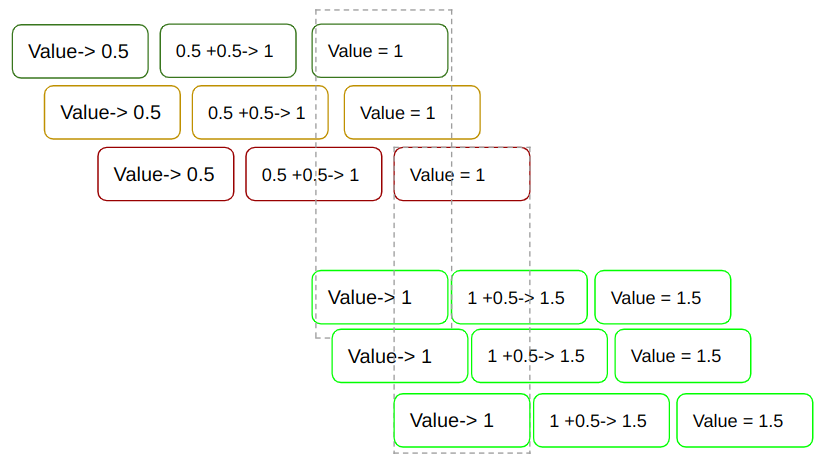

En lancant plusieurs fois la cellule précédente, on a un exemple de "race condition", la fonction est appelée 1,048,576 fois et pourtant les chiffres dans le tableau sont loin de ce résultat.  Plusieurs threads se lancent presque au même moment, cela prends un certain temps à lancer l'exécution et le résultat de la première est ensuite écrasé par le résultat de la 2e, et ainsi de suite.  Lorsque par exemple 100,000+ threads ont étés créés, alors une des premières aura terminée, le résultat (0.5) est alors pris en considération lors du départ de cette thread et ainsi de suite, les prochaines écraseront les suivantes...  Jusqu'à avoir un résultat variable en bout de ligne.  Soit une valeur d'environ 30 au final.  On est loin du million initial.

Pour corriger ce problème, on va alors refaire une fonction qui indique dans quelle thread se trouvera notre exécution de code.  Les dimensions du tableau doivent cependant correspondre au nombre de thread.

In [ ]:
@cuda.jit
def cudakernel1(array):
    thread_position = cuda.grid(1)
    array[thread_position] += 0.5

In [ ]:
array = np.array([0, 1], np.float32)
print('Initial array:', array)

print('Kernel launch: cudakernel1[1, 2](array)')
cudakernel1[1, 2](array)  #2 Threads seront créées

print('Updated array:',array)

Initial array: [0. 1.]
Kernel launch: cudakernel1[1, 2](array)
Updated array: [0.5 1.5]


In [ ]:
array = np.zeros(1024 * 1024, np.float32)
print('Initial array:', array)

print('Kernel launch: cudakernel1[1024, 1024](array)')
cudakernel1[1024, 1024](array)

print('Updated array:', array)

print('The result is correct:', np.all(array == np.zeros(1024 * 1024, np.float32) + 0.5))

Initial array: [0. 0. 0. ... 0. 0. 0.]
Kernel launch: cudakernel1[1024, 1024](array)
Updated array: [0.5 0.5 0.5 ... 0.5 0.5 0.5]
The result is correct: True


cuda.grid(1) va retourner l'index du thread en cours d'exécution, le 1 fourni en paramètre indique que l'on veut un tableau d'une seule dimension en sortie.  Sachant, ceci, si on essaie par exemple de mettre `array[thread_position % 2]` par exemple, on va obtenir sensiblement le même résultat avec le "race condition".  Ce qui indique que la meilleure utilisation serait sur des tableaux de données et qu'on n'aurait pas trop à aller modifier les mêmes données plusieurs fois.  Il existe cependant des méthodes pour exécuter de façon "thread-safe" pour CUDA.

[Partie 2](https://colab.research.google.com/drive/1IjuOLpOCUv0tL_N2uB0bfyRCR1IwHt3d)